#  Tarea 2<br/>Regresión No Lineal
#### Miguel Videla A.<br/>MA5204 Aprendizaje de Máquinas

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

### 1. Carga y Visualización de Datos

In [2]:
# Data load
data = np.genfromtxt('https://raw.githubusercontent.com/GAMES-UChile/Curso-Aprendizaje-de-Maquinas/master/datos/datosT2.txt')
X = data[:,0]
y = data[:,1]

# Data split
X_train = X[0:int(0.75*X.shape[0])]
y_train = y[0:int(0.75*y.shape[0])]
X_test = X[int(0.75*X.shape[0]):]
y_test = y[int(0.75*y.shape[0]):]

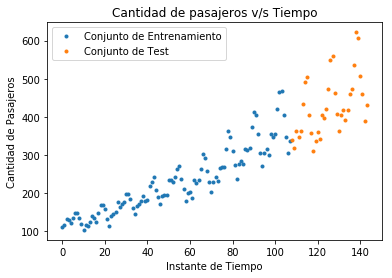

In [3]:
# Data visualization
plt.plot(X_train, y_train, linestyle='', marker='.', label='Conjunto de Entrenamiento')
plt.plot(X_test, y_test, linestyle='', marker='.', label='Conjunto de Test')
plt.xlabel('Instante de Tiempo')
plt.ylabel('Cantidad de Pasajeros')
plt.legend()
plt.title('Cantidad de pasajeros v/s Tiempo')
plt.savefig('01-data_visualization', bbox_inches='tight', dpi=300)
plt.show()

### 2. Modelo Polinomial

In [62]:
# Cost function
def poli_data(x, order=2):
    return np.array([x**i for i in range(0, order + 1)])   

def poli_vec(x, order=2):
    return np.array([poli_data(xi, order) for xi in x])

def f_pol(x, y, theta, m):
    return (theta * poli_vec(x, order=m)).sum(axis=1)

def cost_fun_map(params, *args):
    x = args[0]
    y = args[1]
    m = args[2]
    f = args[-1]
    n = x.shape[0]
    theta = params[0:-1]
    variance = params[-1]
    term_1 = (n / 2.0) * np.log(2 * np.pi * variance)
    term_2 = (m + 1) / 2.0 * np.log(2 * np.pi)
    term_3 = (1 / 2.0) * theta.dot(theta)
    term_4 = (1 / (2.0 * variance)) * ((y - f(x, y, theta, m)) ** 2).sum()
    J = term_1 + term_2 + term_3 + term_4
    return J

In [63]:
# Optimization
params_pol = []
m_array = [1, 2, 3, 4]
for m in m_array:
    init_params = np.random.randn(m + 2)
    init_params[-1] = 100
    args = (X_train, y_train, m, f_pol)
    res = minimize(cost_fun_map, init_params, args=args, method='BFGS')
    params_pol.append(res.x)
params_pol = np.array(params_pol)
print('Polynomial Parameters:')
print(params_pol)

Polynomial Parameters:
[array([ 0.79045252,  3.80964444, 59.9351427 ])
 array([ 7.15833779e-01,  5.10588776e+00, -1.60863340e-02,  5.31088867e+01])
 array([ 7.50714559e-01,  5.99270157e+00, -4.41894074e-02,  1.98548566e-04,
        5.03072356e+01])
 array([ 1.76442274e+00,  1.41738088e+01, -4.39061398e-01,  6.01087965e-03,
       -2.67844302e-05,  1.99630764e+01])]


In [64]:
# Normal distirbution and likelihood
def normal_distribution(y, mean, variance):
    A = 1 / (np.sqrt(2 * np.pi * variance))
    B = np.exp(np.multiply(-1 / (2 * variance), (y - mean) ** 2))
    return np.multiply(A, B)

def likelihood(y, mean, variance):
    return np.prod(normal_distribution(y, mean, variance)).sum()

# Predictions
y_pred_1 = []
for i in range(len(m_array)):
    y_pred_1.append(f_pol(X, y, params_pol[i][:-1], m_array[i]))
y_pred_1 = np.array(y_pred_1)

# Mean Square Error
mse_train_1 = ((y - y_pred_1)[:,0:int(0.75 * X.shape[0])] ** 2).mean(axis=1)
mse_test_1 = ((y - y_pred_1)[:,int(0.75 * X.shape[0]):] ** 2).mean(axis=1)
print('MSE Train:')
print(mse_train_1)
print('MSE Test:')
print(mse_test_1)

# Likelihood
likelihood_1 = []
for i in range(len(m_array)):
    likelihood_1.append(likelihood(y[int(0.75 * X.shape[0]):], y_pred_1[i][int(0.75 * X.shape[0]):], params_pol[i][-1]))
likelihood_1 = np.array(likelihood_1)
print('Likelihood Test:')
print(likelihood_1)

MSE Train:
[3592.22914537 2820.5521578  2530.823389   1761.91089478]
MSE Test:
[  6973.04272219   7093.39184541   5056.6895697  263072.61099098]
Likelihood Test:
[0. 0. 0. 0.]


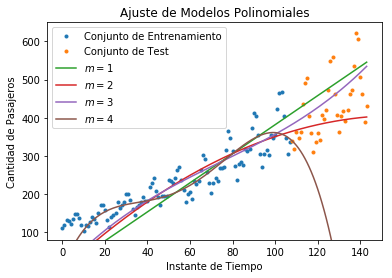

In [65]:
# Polynomial Model 
plt.plot(X_train, y_train, linestyle='', marker='.', label='Conjunto de Entrenamiento')
plt.plot(X_test, y_test, linestyle='', marker='.', label='Conjunto de Test')
for i in range(len(m_array)):
    plt.plot(X, y_pred_1[i], label=r'$m={}$'.format(m_array[i]))
plt.xlabel('Instante de Tiempo')
plt.ylabel('Cantidad de Pasajeros')
plt.ylim([80, 650])
plt.legend()
plt.title('Ajuste de Modelos Polinomiales')
#plt.savefig('02-polynomial_fit', bbox_inches='tight', dpi=300)
plt.show()

### 3. Modelo Polinomial Sinusoidal

In [79]:
# Cost function
def f_sin(x, theta):
    return theta[0] * np.sin(x * theta[1] + theta[2]) * np.exp(theta[3] * x)

def f_pol_sin(x, y, theta_constant, theta_sin):
    return f_pol(x, y, theta_constant[0], theta_constant[0].shape[0]-1) + f_sin(x, theta_sin)
    
def cost_fun_mv(params, *args):
    x = args[0]
    y = args[1]
    theta_constant = args[2]
    f_pol_sin = args[-1]
    n = x.shape[0]
    theta = params[0:-1]
    variance = params[-1]    
    term_1 = (n / 2.0) * np.log(2 * np.pi * variance)
    term_2 = (1 / (2.0 * variance)) * ((y - f_pol_sin(x, y, theta_constant, theta)) ** 2).sum()
    J = term_1 + term_2
    return J

In [106]:
# Optimization
params_sin = []
for i in range(len(m_array)):
    init_params = np.random.randn(5)
    init_params[-2] = 0.01
    init_params[-1] = 10
    args = (X_train, y_train, [params_pol[i][:-1]], f_pol_sin)
    res = minimize(cost_fun_mv, init_params, args=args, method='BFGS', tol=1e-8)
    params_sin.append(res.x)
params_sin = np.array(params_sin)
print('Sinusoid Parameters:')
print(params_sin)

Sinusoid Parameters:
[[-1.76565161e+02 -6.29684966e+00  2.36314695e+02 -4.10051045e+00
   3.44139278e+03]
 [-2.93103118e+02  1.02683749e+01 -6.95015154e+01 -4.88696907e+00
   2.73818350e+03]
 [-1.16231902e+02  3.53789485e-02  4.64627991e+00 -3.68685814e-02
   1.12616322e+03]
 [ 1.44199994e+01  5.13091861e-01 -1.94566098e+01  1.51474788e-02
   9.88032851e+02]]


In [49]:
best_sin_params = np.array([ 1.42567916e+01,  5.11635884e-01, -1.93734186e+01,  1.53079842e-02,
   1.07063540e+03])
best_sin_params

array([ 1.42567916e+01,  5.11635884e-01, -1.93734186e+01,  1.53079842e-02,
        1.07063540e+03])

In [82]:
# Predictions
y_pred_2 = []
for i in range(len(m_array)):
    y_pred_2.append(f_pol(X, y, params_pol[i][:-1], m_array[i]) + f_sin(X, best_sin_params[:-1]))
y_pred_2 = np.array(y_pred_2)

# Mean Square Error
mse_train_2 = ((y - y_pred_2)[:,0:int(0.75 * X.shape[0])] ** 2).mean(axis=1)
mse_test_2 = ((y - y_pred_2)[:,int(0.75 * X.shape[0]):] ** 2).mean(axis=1)
print('MSE Train:')
print(mse_train_2)
print('MSE Test:')
print(mse_test_2)

MSE Train:
[2854.56183327 2036.48262195 1760.12478276  989.97102891]
MSE Test:
[  5486.21257215   4201.72281105   3527.9571936  250167.00956983]


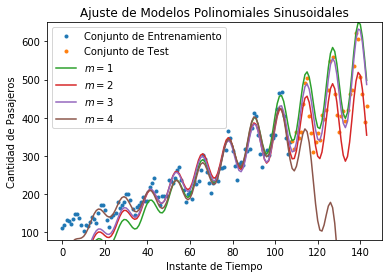

In [84]:
# Polynomic Sinusoidal Model 
plt.plot(X_train, y_train, linestyle='', marker='.', label='Conjunto de Entrenamiento')
plt.plot(X_test, y_test, linestyle='', marker='.', label='Conjunto de Test')
for i in range(len(m_array)):
    plt.plot(X, y_pred_2[i], label=r'$m={}$'.format(m_array[i]))
plt.xlabel('Instante de Tiempo')
plt.ylabel('Cantidad de Pasajeros')
plt.ylim([80, 650])
plt.legend()
plt.title('Ajuste de Modelos Polinomiales Sinusoidales')
#plt.savefig('03-polynomial-sinusoidal_fit', bbox_inches='tight', dpi=300)
plt.show()

### 4. Modelo Polinomial Bi-sinusoidal

In [52]:
# Function
def f_pol_2sin(x, y, theta_constant, theta_sin):
    return f_pol(x, y, theta_constant[0], theta_constant[0].shape[0]-1) + f_sin(x, theta_constant[1]) + f_sin(x, theta_sin)

In [58]:
# Optimization
params_2sin = []
for i in range(len(m_array)):
    init_params = np.random.randn(5)
    init_params[-2] = 0.01
    init_params[-1] = 10
    args = (X_train, y_train, [params_pol[i][:-1], best_sin_params[:-1]], f_pol_2sin)
    res = minimize(cost_fun_mv, init_params, args=args, method='BFGS', tol=1e-18)
    params_2sin.append(res.x)
print('Second Sinusoidal Parameters:')
print(params_2sin)

Second Sinusoidal Parameters:
[array([-126.74811168,    3.61952965, -126.82958682,   -4.76876444,
       2737.5339934 ]), array([-112.97828071,   -2.47830552,   80.23949624,   -4.56522043,
       1926.22868934]), array([-1.12795726e+02,  3.43676318e-02, -1.60055395e+00, -3.44822124e-02,
        3.93892354e+02]), array([ 3620.76736789, -1307.07002879,   889.03895752,  -763.76066916,
         940.00439634])]


In [59]:
# Predictions
y_pred_3 = []
for i in range(len(m_array)):
    y_pred_3.append(f_pol(X, y, params_pol[i][:-1], m_array[i]) + f_sin(X, best_sin_params[:-1]) + f_sin(X, params_2sin[i][:-1]))
y_pred_3 = np.array(y_pred_3)

# Mean Square Error
mse_train_3 = ((y - y_pred_3)[:,0:int(0.75 * X.shape[0])] ** 2).mean(axis=1)
mse_test_3 = ((y - y_pred_3)[:,int(0.75 * X.shape[0]):] ** 2).mean(axis=1)
print('MSE Train:')
print(mse_train_3)
print('MSE Test:')
print(mse_test_3)

MSE Train:
[2726.34905144 1908.75978479  393.8929251   940.05182863]
MSE Test:
[  5486.30493519   4201.4654167    3505.6535746  555190.18251415]


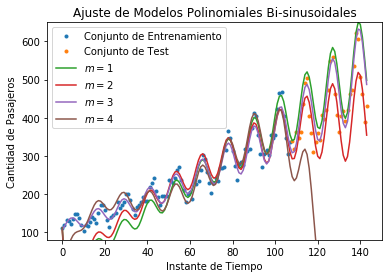

In [61]:
# Polinomyal Bi-sinusoidal Model 
plt.plot(X_train, y_train, linestyle='', marker='.', label='Conjunto de Entrenamiento')
plt.plot(X_test, y_test, linestyle='', marker='.', label='Conjunto de Test')
for i in range(len(m_array)):
    plt.plot(X, y_pred_3[i], label=r'$m={}$'.format(m_array[i]))
plt.xlabel('Instante de Tiempo')
plt.ylabel('Cantidad de Pasajeros')
plt.ylim([80, 650])
plt.legend()
plt.title('Ajuste de Modelos Polinomiales Bi-sinusoidales')
#plt.savefig('04-polynomial-bisinusoidal_fit', bbox_inches='tight', dpi=300)
plt.show()